[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loaded 18 documents.
Saved topic weights to: /Users/user/Desktop/GAITAR-hashed/topic_weights.csv


/var/folders/_w/vqx0wtl16kg3_d6nrgx0yb0r0000gp/T/ipykernel_62429/3469091291.py:100: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

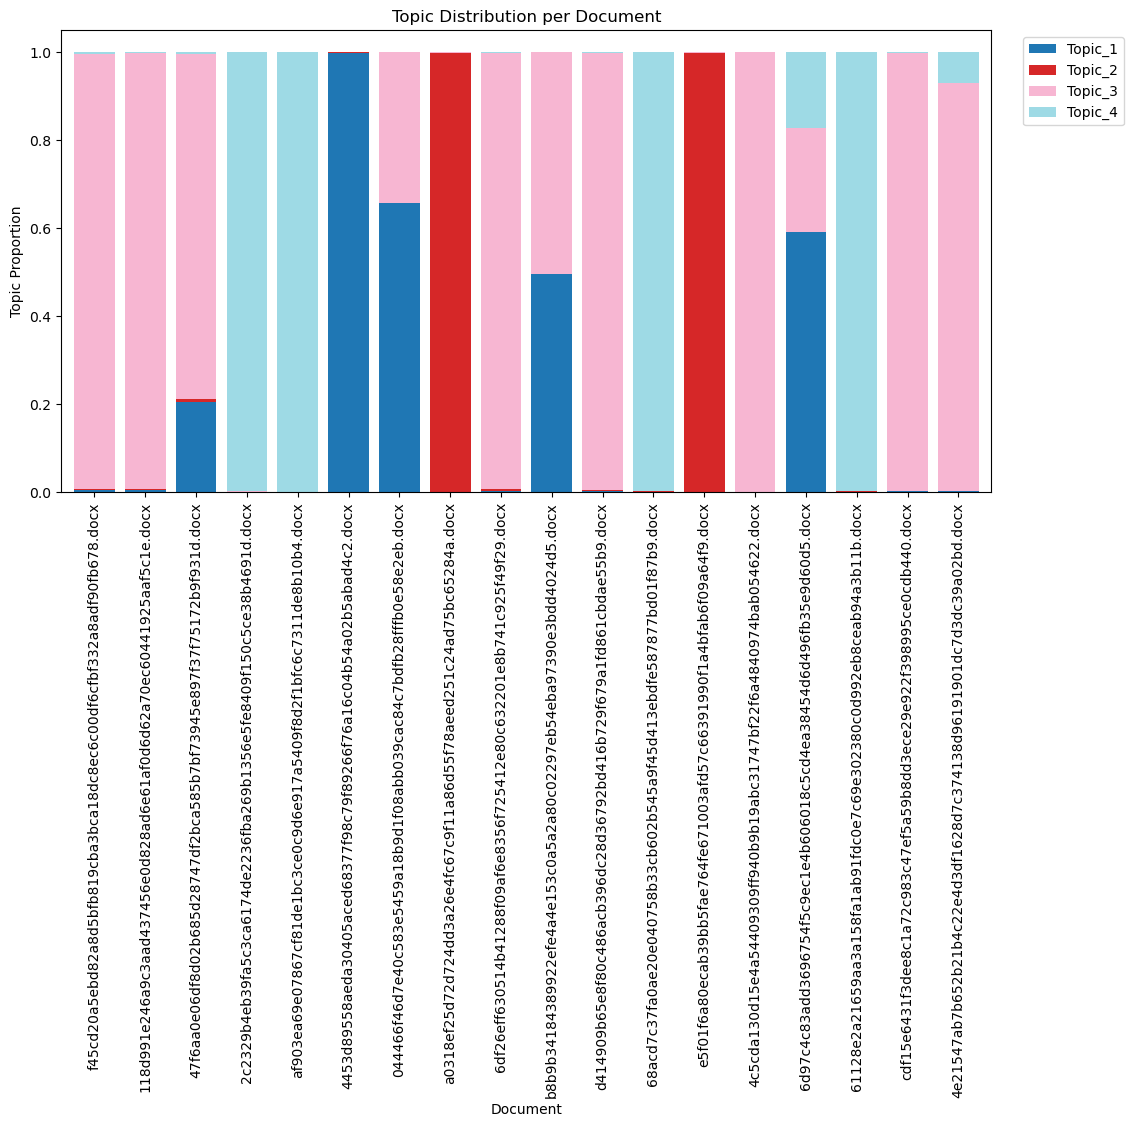

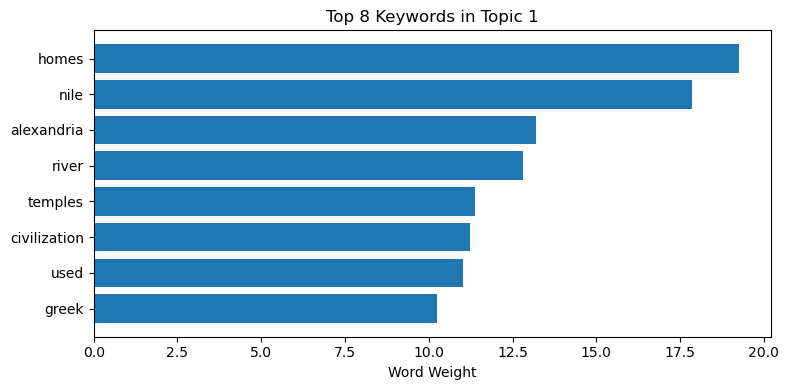

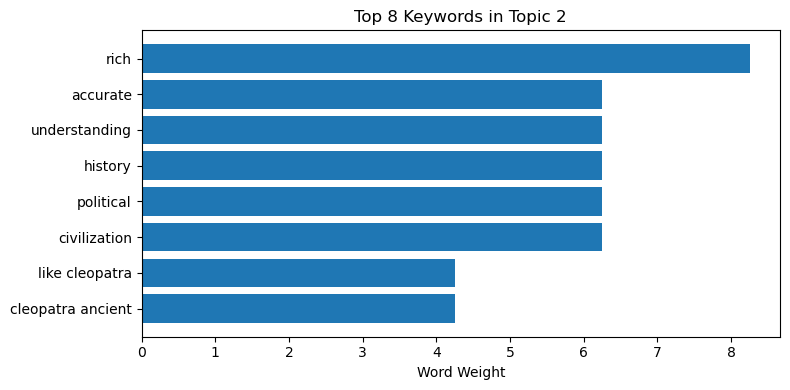

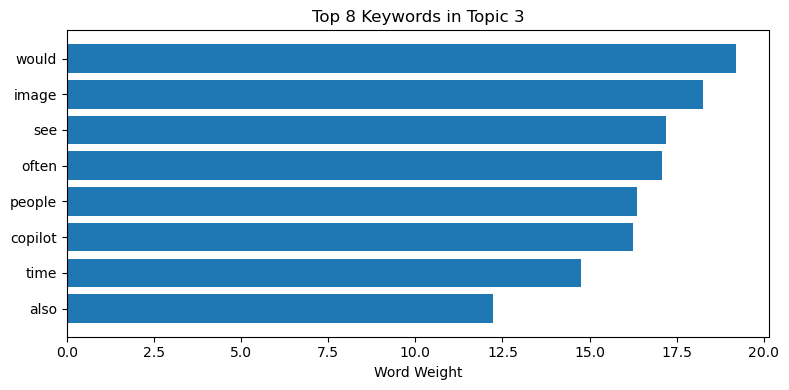

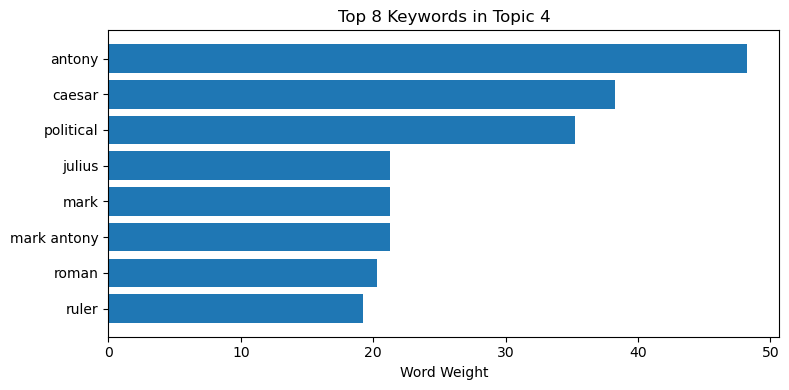

In [1]:
# ================================================
# Full Topic Modeling Pipeline with Visualization
# ================================================


import os
import re
import docx
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

nltk.download('punkt')
nltk.download('stopwords')

# 2) Load all .docx files from your local folder
folder_path = "/Users/user/Desktop/GAITAR-hashed"
docs = []
filenames = []

for fname in os.listdir(folder_path):
    if fname.lower().endswith(".docx"):
        path = os.path.join(folder_path, fname)
        doc = docx.Document(path)
        text = "\n".join([p.text for p in doc.paragraphs])
        docs.append(text)
        filenames.append(fname)

print(f"Loaded {len(docs)} documents.")

# 3) Clean & preprocess text
def clean(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)            # remove numbers
    text = re.sub(r'https?://\S+|\W+', ' ', text)  # remove URLs & non-word chars
    return text

docs_clean = [clean(d) for d in docs]

# 4) Vectorize (unigrams + bigrams)
stop_words = nltk.corpus.stopwords.words('english')
vectorizer = CountVectorizer(
    stop_words=stop_words,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)
)
dtm = vectorizer.fit_transform(docs_clean)

# 5) Fit LDA model
n_topics = 4   # adjust as desired
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=15,
    random_state=42
)
lda.fit(dtm)

# 6) Extract top words per topic
feature_names = vectorizer.get_feature_names_out()
top_n = 8
topic_keywords = {}
for t in range(n_topics):
    top_indices = lda.components_[t].argsort()[-top_n:][::-1]
    words = [feature_names[i] for i in top_indices]
    topic_keywords[f"Topic {t+1}"] = words

# 7) Build document-topic distribution DataFrame
doc_topic_dist = lda.transform(dtm)
topic_df = pd.DataFrame(
    doc_topic_dist,
    columns=[f"Topic_{i+1}" for i in range(n_topics)]
)
topic_df['Filename'] = filenames

# 8) Save topic weights to CSV
csv_path = os.path.join(folder_path, "topic_weights.csv")
topic_df.to_csv(csv_path, index=False)
print(f"Saved topic weights to: {csv_path}")

# 9) Visualize: Stacked bar chart of topic distribution per document
plt.figure(figsize=(12, 6))
topic_df_sorted = topic_df.set_index('Filename')
topic_df_sorted.plot(
    kind='bar',
    stacked=True,
    figsize=(12,6),
    colormap='tab20',
    width=0.8
)
plt.title("Topic Distribution per Document")
plt.xlabel("Document")
plt.ylabel("Topic Proportion")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

# 10) Visualize: Bar plot of top keywords for each topic
for t, words in topic_keywords.items():
    weights = [lda.components_[int(t.split()[1]) - 1][feature_names.tolist().index(w)] for w in words]
    plt.figure(figsize=(8, 4))
    plt.barh(words[::-1], weights[::-1])  # reverse for descending order
    plt.xlabel("Word Weight")
    plt.title(f"Top {top_n} Keywords in {t}")
    plt.tight_layout()
    plt.show()
